# Final Team Project - SliceWise: Pricing, Menu, and Ratings Analytics for U.S. Pizza Restaurants 

### Team 9: Duy-Anh Dang, Arjun Venkatesh, and Nanch Walker 

Course: ADS 505 Applied Data Science for Business

Instructor: Jules Malin

## Introduction

## Problem Statement

Using the Datafiniti “Pizza Restaurants and the Pizza They Sell (May 2019)” dataset, we will deliver pricing and assortment insights for pizza operators.  

Objectives: 

 

    Profile geographic coverage and market density. 

    Quantify price corridors (store-level priceRangeMin/Max; item-level menus.amountMin/Max). 

    Identify outliers and dispersion by state/city and common SKUs. 

    Provide executive recommendations on pricing, assortment focus, and expansion targets. 

## Exploratory Data Analysis

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import kagglehub
import os 

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/pizza-restaurants-and-the-pizza-they-sell")

print("Path to dataset files:", path)

Path to dataset files: /Users/nancywalker/.cache/kagglehub/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell/versions/2


In [3]:
#Files downloaded
files = os.listdir(path)

In [4]:
# Select the first CSV file (assuming it exists)
csv_files = [f for f in files if f.endswith(".csv")] # Get all CSV file

# Load the first CSV file found
data1 = pd.read_csv(os.path.join(path, csv_files[0]))

# Load the second dataset
data2 = pd.read_csv(os.path.join(path, csv_files[1]))

In [5]:
# print the first few rows of the first dataset
print(data1.head())

                     id                                  address  \
0  AVwc_6KEIN2L1WUfrKAH  Cascade Village Mall Across From Target   
1  AVwc_6KEIN2L1WUfrKAH  Cascade Village Mall Across From Target   
2  AVwc_6qRByjofQCxkcxw                     148 S Barrington Ave   
3  AVwc_6qRByjofQCxkcxw                     148 S Barrington Ave   
4  AVwc_6qRByjofQCxkcxw                     148 S Barrington Ave   

                       categories         city country  \
0                     Pizza Place         Bend      US   
1                     Pizza Place         Bend      US   
2  American Restaurant,Bar,Bakery  Los Angeles      US   
3  American Restaurant,Bar,Bakery  Los Angeles      US   
4  American Restaurant,Bar,Bakery  Los Angeles      US   

                                                keys   latitude   longitude  \
0  us/or/bend/cascadevillagemallacrossfromtarget/...  44.102665 -121.300797   
1  us/or/bend/cascadevillagemallacrossfromtarget/...  44.102665 -121.300797   
2  us

In [6]:
# print the first few rows of the second dataset
print(data2.head())

                     id             dateAdded           dateUpdated  \
0  AVz3Y-7h3D1zeR_xDAqm  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z   
1  AVweGPFF_7pvs4fzAAzQ  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z   
2  AVwdRGa9_7pvs4fz4E3K  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z   
3  AVwdX4psIN2L1WUfvJB1  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z   
4  AVwdaeTtkufWRAb55pSH  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z   

             address                                         categories  \
0   4203 E Kiehl Ave  Pizza,Restaurant,American restaurants,Pizza Pl...   
1  25 E Camelback Rd                      Pizza,Pizza Place,Restaurants   
2    3703 Paxton Ave                 Restaurant,Pizza Place,Restaurants   
3    30495 John R Rd       Pizza,Carry-out food,Pizza Place,Restaurants   
4   3600 Eastern Ave  Pizza,American restaurants,Pizza Place,Pizza e...   

               primaryCategories             city country  \
0  Accommodation & Food Services         Sherwood      US   


There are two datasets to use for this project.

data1 is a list of over 3,500 pizzas from multiple restaurants. 
- curated dataset of pizza-only restaurants in Datafiniti's business database. 
- Useful for pizza-specific analyses.

Data2 is a list of 10,000 pizza restaurants in Datafiniti's business database, spanning **from January 2018 to May 2019**.
- larger, broader subset of Datafiniti's business database.
- useful to analyze pizza restaurants in comparison to other types of restaurants. 

In [7]:
data1.info()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3510 non-null   object 
 1   address             3510 non-null   object 
 2   categories          3510 non-null   object 
 3   city                3510 non-null   object 
 4   country             3510 non-null   object 
 5   keys                3510 non-null   object 
 6   latitude            3510 non-null   float64
 7   longitude           3510 non-null   float64
 8   menuPageURL         610 non-null    object 
 9   menus.amountMax     2948 non-null   float64
 10  menus.amountMin     2948 non-null   float64
 11  menus.currency      2951 non-null   object 
 12  menus.dateSeen      3510 non-null   object 
 13  menus.description   1526 non-null   object 
 14  menus.name          3510 non-null   object 
 15  name                3510 non-null   object 
 16  postal

This project uses two datasets. 

Dataset 1: 8358_1.csv 
- This dataset contains information on pizza restaurants and the types of Pizza they sell.
- It has 3,519 rows and 21 columns.
- There are a few features with missing values.

Dataset 2: Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv
- list of 10,000 restaurants in Datafiniti's business database between January 2018 and May 2019
- There are 24 feature columns
- Business listings include a variation of the phrase Pizza within the categories and menu.name variables 
- fields have been flattened to make it easier to work with
- This dataset is a sample of a larger dataset that is available through Datafiniti's business database.


## Data2 Datafiniti Pizza Restaurants and the Pizza They Sell (May19)

In [8]:
# Data distribution
data2.describe()

,latitude,longitude,menus.amountMax,menus.amountMin,priceRangeMin,priceRangeMax
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.371895,-90.063800,14.032670,13.416902,4.655500,27.764200
std,4.573537,17.340379,17.607233,10.742678,9.828412,6.017526
min,21.421326,-157.802443,0.000000,0.000000,0.000000,7.000000
25%,34.422946,-104.801126,8.490000,8.000000,0.000000,25.000000
50%,40.118880,-82.909949,13.390000,12.990000,0.000000,25.000000
75%,40.905048,-75.194741,17.950000,16.990000,0.000000,25.000000
max,64.850500,-71.946170,1395.000000,243.000000,50.000000,55.000000


In [9]:
# Check for missing values
data1.isnull().sum()

id                       0
address                  0
categories               0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           2900
menus.amountMax        562
menus.amountMin        562
menus.currency         559
menus.dateSeen           0
menus.description     1984
menus.name               0
name                     0
postalCode              26
priceRangeCurrency    1953
priceRangeMin         1953
priceRangeMax         1953
province                 0
dtype: int64

There are a few features with missing values.

- menuPageURL - 2,900 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column
- menu.amountMax - 562 missing values ( Maximum price of the menu item), impute with median
- menus.amountMin - 562 missing values ( Minimum price of the menu item), impute with median
- menus.currency - 559 missing values ( Currency of the menu item price), impute with mode
- menus.description - 1984 missing values ( Description of the menu item)
    - Options: drop column, impute with placeholder string (for NLP), or transform to binary variable
- postalCode - 26 missing values ( Postal code of the business), impute with mode
- priceRangeCurrency - 1953 missing values ( Currency of the price range), impute with mode
- priceRangeMin - 1953 missing values ( Minimum price of the price range), impute with median
- priceRangeMax - 1953 missing values ( Maximum price of the price range), impute with median


In [10]:
# Remove identifier columns for modeling
data2_cleaned = data2.drop(columns=['id', 'categories', 'address', 'keys', 'menuPageURL']).copy()

# Impute missing values for numeric columns with the mean
num_cols = data2_cleaned.select_dtypes(include=['float64', 'int64']).columns
data2_cleaned[num_cols] = data2_cleaned[num_cols].fillna(data2_cleaned[num_cols].mean())

# Impute missing values for categorical columns with the mode
cat_cols = ['menus.currency', 'postalCode','priceRangeCurrency']
for col in cat_cols:
    mode_value = data2_cleaned[col].mode()[0]
    data2_cleaned[col] = data2_cleaned[col].fillna(mode_value)

# Create binary feature for menus.description and drop original column
data2_cleaned['has_description'] = np.where(data2_cleaned['menus.description'].notnull(), 1, 0)
data2_cleaned = data2_cleaned.drop(columns=['menus.description'])

# Verify no missing values remain
data2_cleaned.isnull().sum()

dateAdded             0
dateUpdated           0
primaryCategories     0
city                  0
country               0
latitude              0
longitude             0
menus.amountMax       0
menus.amountMin       0
menus.currency        0
menus.dateSeen        0
menus.name            0
name                  0
postalCode            0
priceRangeCurrency    0
priceRangeMin         0
priceRangeMax         0
province              0
has_description       0
dtype: int64

In [11]:
print(data2_cleaned.head())

              dateAdded           dateUpdated              primaryCategories  \
0  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z  Accommodation & Food Services   
1  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z  Accommodation & Food Services   
2  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z  Accommodation & Food Services   
3  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z  Accommodation & Food Services   
4  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z  Accommodation & Food Services   

              city country   latitude   longitude  menus.amountMax  \
0         Sherwood      US  34.832300  -92.183800             7.98   
1          Phoenix      US  33.509266 -112.073044             6.00   
2       Cincinnati      US  39.144883  -84.432685             6.49   
3  Madison Heights      US  42.516669  -83.106630             5.99   
4        Baltimore      US  39.286630  -76.566984             5.49   

   menus.amountMin menus.currency  \
0             7.98            USD   
1             6.00      

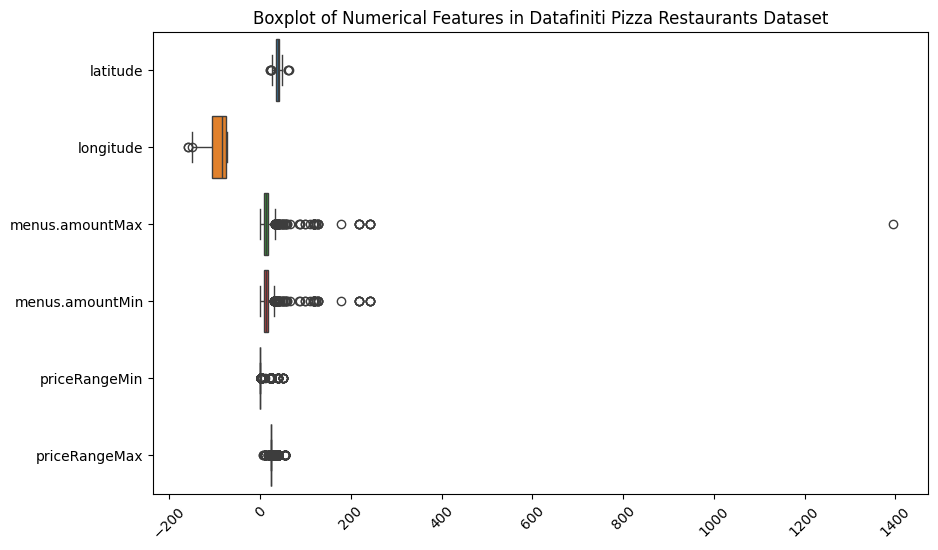

In [12]:
# Select numerical columns in Dataset 2
num_columns = data2_cleaned.select_dtypes(include=['float64','int64']).columns

# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_cols], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()


Menus.amountMax has an extreme outlier of a pizza that cost $1,395. This extreme value may be due to a data entry error or an expensive restaurant selling a luxury pizza. The outlier can be removed for analysis

In [13]:
# remove the outlier in menus.amountMax
data2_cleaned = data2_cleaned[data2_cleaned['menus.amountMax']<500]


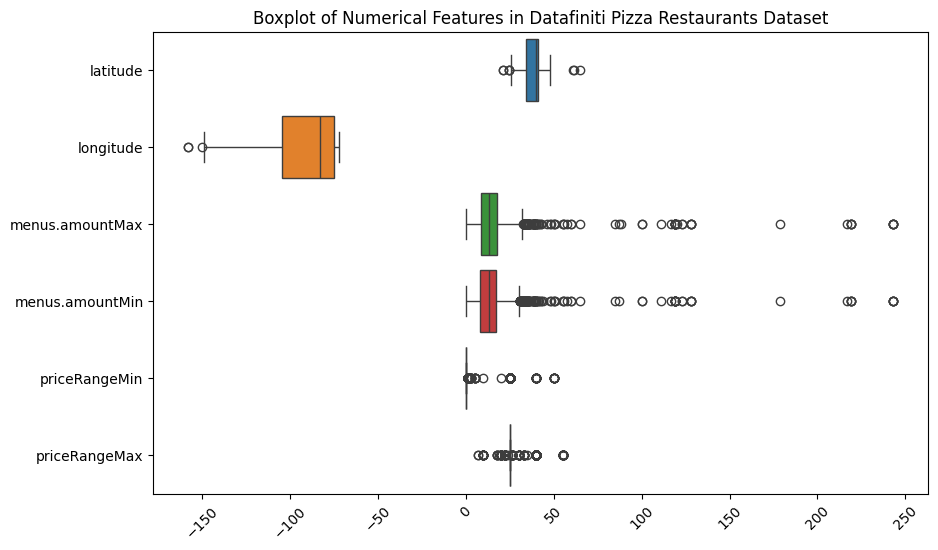

In [14]:
# Recheck data distribution after removig outlier
# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_cols], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()

A clear distribution of numerical feature can be seen once the extream outleir is removed. 

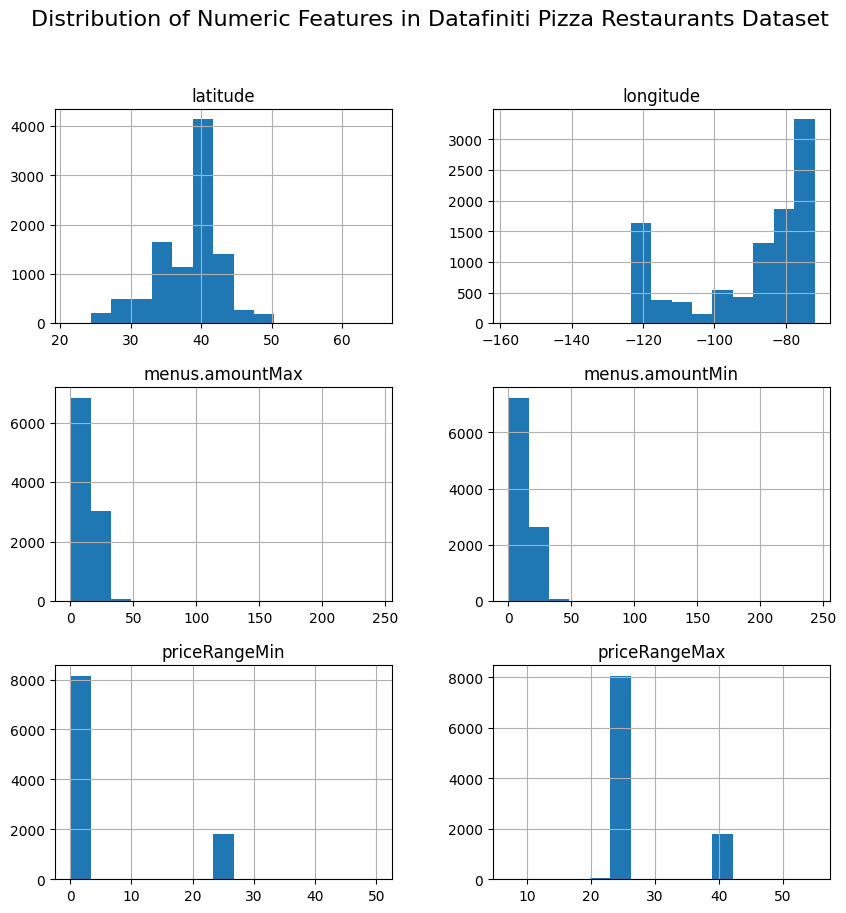

In [15]:
# Feature distribution of numeric features in Dataset 2 
data2_cleaned[num_cols].hist(figsize=(10,10),bins=15)
plt.suptitle("Distribution of Numeric Features in Datafiniti Pizza Restaurants Dataset", fontsize =16)
plt.show()

This histogram also provides a clear visualization of the distribution of the numeric feature. 

Longitude and latitude are continuous variables and display pizza location information.
-Options: keep as is, view mapping, compute distance reference point, group into regions, or use postal code/ city/ province/state to group instead of raw coordinates. 

menus.ammount Max and Min are continuous variabels that display the price range of menu items. These variables are skewed right. (will need normalization/transformation for modeling)

priceRange Min and Max look as though they are categorical variables with numeric values. Likely displaying similar information to menus.amount Max and Min.

<Axes: >

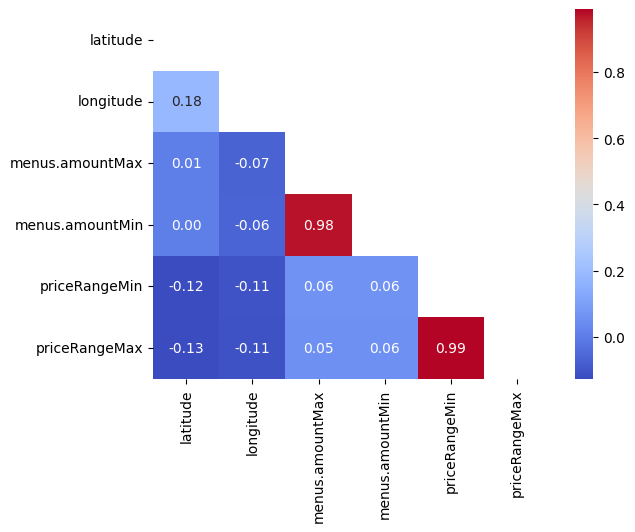

In [16]:
# Plot heatmap to visualize correlations
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[num_cols].corr()))

sns.heatmap(data2_cleaned[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

Menus.amountMin and menus.amountMax are highly correlated (r = 0.98). Combine the average of these variables for more flexible option of modeling pricing.

pricRangeMin and priceRangeMax are also highly correlated (0.99). Combine the average of these variables for more flexible option of modeling pricing.

In [17]:
# Combine highly correlated features into average features
data2_cleaned['menus_amount_avg'] = (data2_cleaned['menus.amountMin'] + data2_cleaned['menus.amountMax']) / 2
data2_cleaned['priceRange_avg'] = (data2_cleaned['priceRangeMin'] + data2_cleaned['priceRangeMax']) / 2 
# Drop original highly correlated features
data2_cleaned = data2_cleaned.drop(columns=['menus.amountMin', 'menus.amountMax', 'priceRangeMin', 'priceRangeMax'])

In [18]:
# Check the unique values across all columns in Dataset 2
data2_cleaned.nunique()

dateAdded             2214
dateUpdated           2193
primaryCategories        8
city                  1028
country                  1
latitude              2284
longitude             2284
menus.currency           1
menus.dateSeen        6303
menus.name            4749
name                  1827
postalCode            1771
priceRangeCurrency       1
province                44
has_description          2
menus_amount_avg       858
priceRange_avg          18
dtype: int64

**Timestamp variables**: dateAdded, dateUpdated, menus.dateSeen
- extract features: year, month, day, day of week, elapsed time since (for dateAdded and dateUpdated)
- drop after extracting features (high-cardinality categorical variable)

**Drop**

- County, meanus.currency, and priceRangeCurrency only have one unique value. These columns can be dropped.
- name high cardinality categorical variable, drop

**Leave as is**

has_descriptio is a binary variable that was created to indicate if a menue has a diescription or not.

**one-hot encoded for modeling**

low-cardinality categorical variables: 
- primaryCategories: pizza type
- province: region-level location

One-Hot encoding will occur in model pipeline to avoid dummy variable trap


high-cardinality categorical variables: menus.dateSeen
- city: city-level location; could blow up model with too many features. To capture city-level location, kepp top N cities and group the rest into "Other"
- postalCode: zip code-level location; could blow up model with too many features, drop or use for grouping

**Location**
longitude, latitude
- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

**Dependent variables for modeling:**

priceRangeAverage or menus_amount_avg

Dependent Variable: Goal is to recommend pricing strategies for pizza restaurants.

menu.amountMax: Maximum price of the menu item

- Continuous variable, good for regression modeling
- recommend exact menu pricing based on other features

or 

priceRangeMax: Maximum price of the price range

- Ordinal variable, good for classification modeling
- recommend price range categories based on other features (ie: budget, mid-range, premium)




In [19]:
# Drop variable with one unique value and high-cardinality variables
data2_cleaned = data2_cleaned.drop(columns=['country','menus.currency', 'priceRangeCurrency', 'postalCode', 'name'])

## Handle Timestamp Variables

In [20]:
# check the formate of the data and time variables
print("dateAdded: \n", data2_cleaned['dateAdded'].head(2))
print("dateUpdated: \n", data2_cleaned['dateUpdated'].head(2))
print("menus.dateSeen: \n", data2_cleaned['menus.dateSeen'].head(2))


dateAdded: 
 0    2017-06-30T05:05:40Z
1    2016-04-02T04:02:49Z
Name: dateAdded, dtype: object
dateUpdated: 
 0    2019-05-01T15:43:09Z
1    2019-05-01T15:27:50Z
Name: dateUpdated, dtype: object
menus.dateSeen: 
 0    2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...
1    2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...
Name: menus.dateSeen, dtype: object


dataAdded and dataUpdated can easily be converted to datetime format.
menus.dateSeen has many comma-separated values from multiple updates. Tricky to convert to datetime format. 
- Dropping this variable will still capture price recomenations but will lose seasonality trends in pricing.
- keeping this variable will show seasonality trends in pricing but will make modeling more difficult.
- will drop this variable for simplicity and return to it if time permits. 

In [21]:
# Change data formate of date columns to datetime data type
data2_cleaned['dateAdded'] = pd.to_datetime(data2_cleaned['dateAdded'], errors='coerce', utc=True)
data2_cleaned['dateUpdated'] = pd.to_datetime(data2_cleaned['dateUpdated'], errors='coerce', utc=True)

In [22]:
# Extract year, month, day, and day of week from dateAdded 
data2_cleaned['dateAdded_year'] = data2_cleaned['dateAdded'].dt.year 
data2_cleaned['dateAdded_month'] = data2_cleaned['dateAdded'].dt.month 
data2_cleaned['dateAdded_day'] = data2_cleaned['dateAdded'].dt.day 
data2_cleaned['dateAdded_dayofweek'] = data2_cleaned['dateAdded'].dt.dayofweek 
# Elapsed time since dateAdded 
data2_cleaned['days_since_added'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateAdded']).dt.days 
#  Extract year, month, day, and day of week from dateUpdated 
data2_cleaned['dateUpdated_year'] = data2_cleaned['dateUpdated'].dt.year 
data2_cleaned['dateUpdated_month'] = data2_cleaned['dateUpdated'].dt.month 
data2_cleaned['dateUpdated_day'] = data2_cleaned['dateUpdated'].dt.day 
data2_cleaned['dateUpdated_dayofweek'] = data2_cleaned['dateUpdated'].dt.dayofweek 
# Elapsed time since dateUpdated 
data2_cleaned['days_since_updated'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateUpdated']).dt.days 

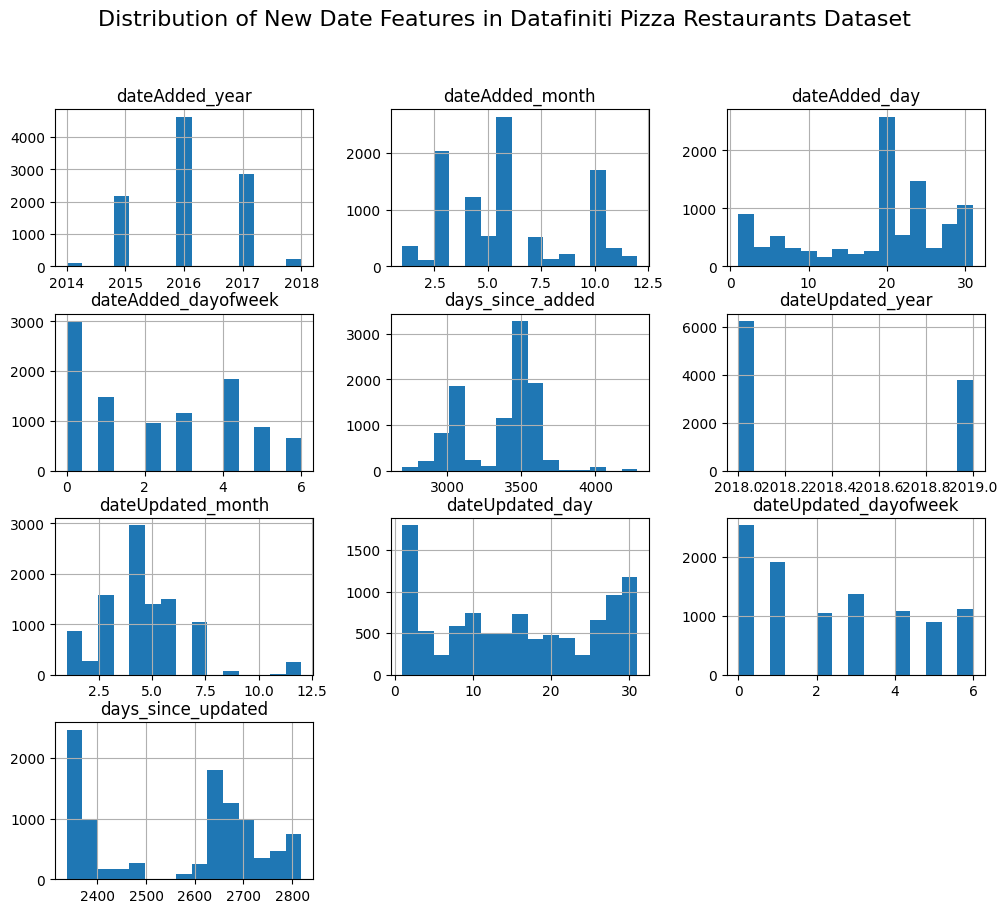

In [23]:
# visulize the distribution of the new date features
new_date_features = ['dateAdded_year', 'dateAdded_month', 'dateAdded_day', 'dateAdded_dayofweek',
                     'days_since_added', 'dateUpdated_year', 'dateUpdated_month', 'dateUpdated_day',
                     'dateUpdated_dayofweek', 'days_since_updated']
data2_cleaned[new_date_features].hist(figsize=(12,10), bins=15)
plt.suptitle("Distribution of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()  

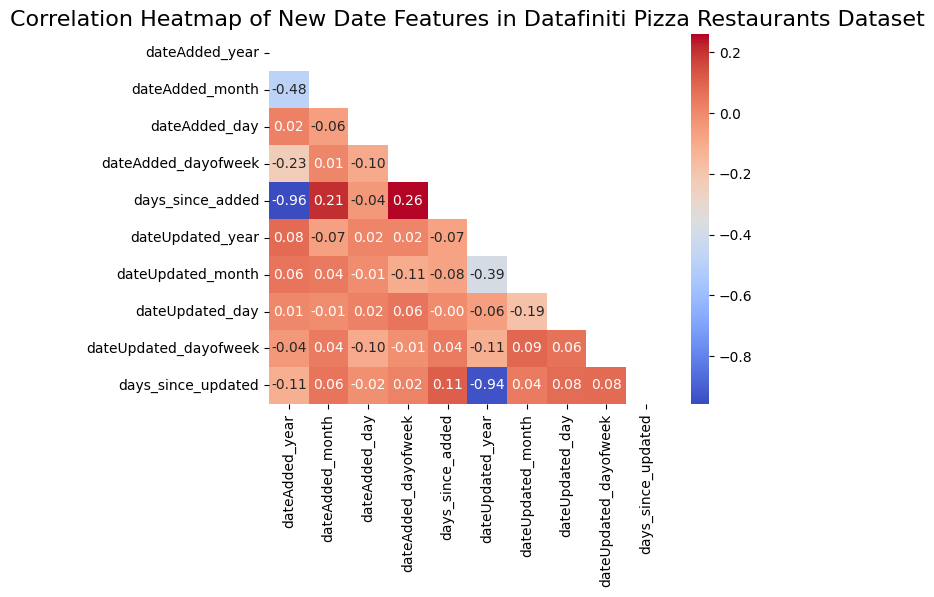

In [24]:
# Check the correlation of the new date features
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[new_date_features].corr()))
sns.heatmap(data2_cleaned[new_date_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

dateAdded_year is highly correlated with days_since_added and moderiate correlation with dateAdded_month. Drop dateAdded_year to reduce multicollinearity.

dateUpdated_year is highly correlated with days_since_updated and moderiate correlation with dateUpdated_month. Drop dateUpdated_year to reduce multicollinearity.


In [25]:
# Drop original date columns and newly created year columns to reduce multicollinearity
data2_cleaned = data2_cleaned.drop(columns=['dateAdded', 'dateUpdated', 'menus.dateSeen', 'dateAdded_year', 'dateUpdated_year'])

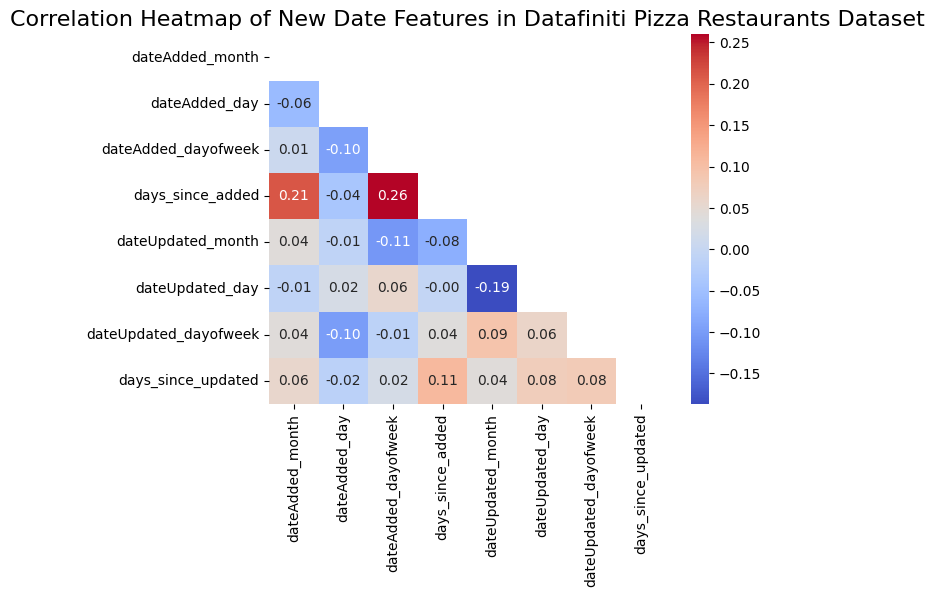

In [26]:
# drop highly correlated features from new features
new_date_features.remove('dateAdded_year')
new_date_features.remove('dateUpdated_year')
# Check correlation heatmap again
plt.figuresize=(12,10)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[new_date_features].corr()))
sns.heatmap(data2_cleaned[new_date_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

New Data Features are no longer highly correlated with each other.Check correlation with all numeric features to ensure no other high correlations exist.

In [27]:
# Check data types 
data2_cleaned.dtypes

primaryCategories         object
city                      object
latitude                 float64
longitude                float64
menus.name                object
province                  object
has_description            int64
menus_amount_avg         float64
priceRange_avg           float64
dateAdded_month            int32
dateAdded_day              int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_day            int32
dateUpdated_dayofweek      int32
days_since_updated         int64
dtype: object

In [28]:
# All numeric features in Dataset 2
all_numeric_features = data2_cleaned.select_dtypes(include=['float64','int64', 'int32']).columns
print("All numeric features in Dataset 2:\n", all_numeric_features)

All numeric features in Dataset 2:
 Index(['latitude', 'longitude', 'has_description', 'menus_amount_avg',
       'priceRange_avg', 'dateAdded_month', 'dateAdded_day',
       'dateAdded_dayofweek', 'days_since_added', 'dateUpdated_month',
       'dateUpdated_day', 'dateUpdated_dayofweek', 'days_since_updated'],
      dtype='object')


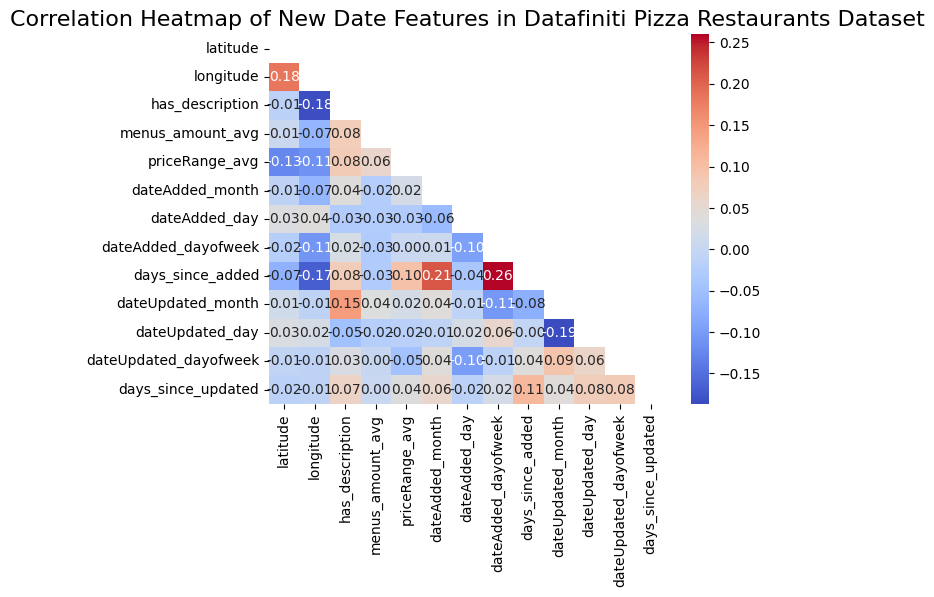

In [29]:
# Check correlation heatmap of all numeric features to ensure no other high correlations exist
plt.figuresize=(12,10)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[all_numeric_features].corr()))
sns.heatmap(data2_cleaned[all_numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Most numeric features are showing low correlation with each other. Also, low correlation with the dependent variable's priceRangeAverage and menus_amount_avg. Linear relationships are weak, so tree-based models may perform better.

## Longitude and Latitude and city 

- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

- city: city-level location; could blow up model with too many features. To capture city-level location, keep top N cities and group the rest into "Other"

In [30]:
# Group into regions based on longitude and latitude
# Define function to categorize into regions
def categorize_region(lat, lon):
    if lat >= 40.0:
        return 'North'
    elif lat <= 30.0:
        return 'South'
    elif lon <= -120.0:
        return 'West'
    elif lon >= -80.0:
        return 'East'
    else:
        return 'Central'

data2_cleaned['region'] = data2_cleaned.apply(lambda row: categorize_region(row['latitude'], row['longitude']), axis=1)
# Keep region and drop original longitude and latitude for tree-based models

In [31]:
# Create a grouped city variable
top_cities = data2_cleaned['city'].value_counts().nlargest(10).index
data2_cleaned['city_grouped'] = data2_cleaned['city'].apply(lambda x: x if x in top_cities else 'Other')
# Drop original city column
data2_cleaned = data2_cleaned.drop(columns=['city'])

In [32]:
print(data2_cleaned.head())

               primaryCategories   latitude   longitude    menus.name  \
0  Accommodation & Food Services  34.832300  -92.183800  Cheese Pizza   
1  Accommodation & Food Services  33.509266 -112.073044  Pizza Cookie   
2  Accommodation & Food Services  39.144883  -84.432685  Pizza Blanca   
3  Accommodation & Food Services  42.516669  -83.106630   Small Pizza   
4  Accommodation & Food Services  39.286630  -76.566984     Pizza Sub   

  province  has_description  menus_amount_avg  priceRange_avg  \
0       AR                0              7.98            12.5   
1       AZ                0              6.00            12.5   
2       OH                1              6.49            12.5   
3       MI                0              5.99            32.5   
4       MD                0              5.49            12.5   

   dateAdded_month  dateAdded_day  dateAdded_dayofweek  days_since_added  \
0                6             30                    4              3008   
1                4

## Data Wrangling and Pre-Processing

In [33]:
# Group rare classes in priceRange_avg to avoid value error when splitting data into train and test sets with stratify=y
# Check the distribution of priceRange_avg
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5    7979
32.5    1801
13.5      54
13.0      31
11.5      28
47.5      21
10.5      18
15.0      16
5.0       16
52.5       9
17.5       8
16.5       5
10.0       4
14.0       4
3.5        2
18.0       1
14.5       1
25.0       1
Name: count, dtype: int64


In [34]:
# Group rare classes into 'Other'
rare_classes = data2_cleaned['priceRange_avg'].value_counts()[data2_cleaned['priceRange_avg'].value_counts() < 10].index
data2_cleaned['priceRange_avg'] = data2_cleaned['priceRange_avg'].apply(lambda x: 'Other' if x in rare_classes else x)

# Check the distribution again
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5     7979
32.5     1801
13.5       54
Other      35
13.0       31
11.5       28
47.5       21
10.5       18
15.0       16
5.0        16
Name: count, dtype: int64


10 main classes with average price ranges grater than 10 samples. Much more stable for classification.

In [ ]:
# Drop dependent variable not in use 
data2_cleaned = data2_cleaned.drop(columns=['menus_amount_avg']) # Target variable: recomended exact menue price 
# Separate features and target variable
X = data2_cleaned.drop(columns=['priceRange_avg'])
y = data2_cleaned['priceRange_avg'] # Target variable: recomended price range average 

priceRange_avg produced the value error " The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2." When splitting the data into train and test sets with stratify=y. This error may be due to the fact that priceRange_avg has a band with one sample.

menus_amount_avg is a continuous variable that is good for regression modeling. The goal is to recommend exact menu pricing based on other features.

priceRange_avg is an ordinal variable that is good for classification modeling. The goal is to recommend price range categories based on other features (ie: budget, mid-range, premium).

- Option to use priceRange_avg: group rare classes or bin into fewer categories to avoid value error when splitting data into train and test sets.

Previously it was determiend that numeric variables were not highly correlated with the target. Using priceRange_avg while grouping rare classes may improve model performance. Once model performance is satisfactory and the drivers of pricing are understood, menus_amountAvg can be used for regression modeling.

In [36]:
# Make all classes strings for classification modeling
y = y.astype(str)

### Data Splitting

In [37]:
# Split the data into training and validation sets
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Split validation data into validation and test sets
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, random_state=1, stratify=temp_y)

# Check the shape of the predictors in the datasets
print(train_X.shape, valid_X.shape, test_X.shape)

(5999, 16) (2000, 16) (2000, 16)


In [38]:
data2_cleaned.dtypes

primaryCategories         object
latitude                 float64
longitude                float64
menus.name                object
province                  object
has_description            int64
priceRange_avg            object
dateAdded_month            int32
dateAdded_day              int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_day            int32
dateUpdated_dayofweek      int32
days_since_updated         int64
region                    object
city_grouped              object
dtype: object

In [39]:
linear_features = ['primaryCategories', 'menus.name','province','has_description','dateAdded_month', 'dateAdded_day', 'dateAdded_dayofweek',
                        'days_since_added', 'dateUpdated_month', 'dateUpdated_day', 'dateUpdated_dayofweek', 'days_since_updated', 'region']
tree_features = ['primaryCategories', 'latitude', 'longitude', 'menus.name','province','has_description','dateAdded_month', 'dateAdded_day', 'dateAdded_dayofweek',
                        'days_since_added', 'dateUpdated_month', 'dateUpdated_day', 'dateUpdated_dayofweek', 'days_since_updated', 'city_grouped']

# Make sure all features exist in the datasets
linear_features = [c for c in linear_features if c in train_X.columns]
tree_features   = [c for c in tree_features   if c in train_X.columns]
print("Linear features:\n", linear_features)
print("Tree features:\n", tree_features)

Linear features:
 ['primaryCategories', 'menus.name', 'province', 'has_description', 'dateAdded_month', 'dateAdded_day', 'dateAdded_dayofweek', 'days_since_added', 'dateUpdated_month', 'dateUpdated_day', 'dateUpdated_dayofweek', 'days_since_updated', 'region']
Tree features:
 ['primaryCategories', 'latitude', 'longitude', 'menus.name', 'province', 'has_description', 'dateAdded_month', 'dateAdded_day', 'dateAdded_dayofweek', 'days_since_added', 'dateUpdated_month', 'dateUpdated_day', 'dateUpdated_dayofweek', 'days_since_updated', 'city_grouped']


In [40]:
# Create variables for modelign pipeline
# Linear
train_X_linear = train_X[linear_features].copy()
valid_X_linear = valid_X[linear_features].copy()
test_X_linear  = test_X[linear_features].copy()

# Tree
train_X_tree = train_X[tree_features].copy()
valid_X_tree = valid_X[tree_features].copy()
test_X_tree  = test_X[tree_features].copy()

## Modeling Strategy

Uses a classification model to predict the price range within the price range categories. Then use regression to determine a specific price amount. 

Next steps:

Find the best classification model to predict priceRange_avg
- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Evaluate model performance with cross-validation

Find the best regression model to predict menus_amount_avg
- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Evaluate model performance with cross-validation

In [41]:
# define model pipeline preprocessing steps
lin_num = [c for c in linear_features if train_X_linear[c].dtype in ['float64','int64', 'int32']]
lin_cat = [c for c in linear_features if train_X_linear[c].dtype == 'object']
tree_num = [c for c in tree_features if train_X_tree[c].dtype in ['float64','int64', 'int32']]
tree_cat = [c for c in tree_features if train_X_tree[c].dtype == 'object']

# Preprocessing for numerical data: StandardScaler
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
linear_pre = ColumnTransformer([
    ('num', StandardScaler(), lin_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lin_cat)
], remainder='drop')

tree_pre = ColumnTransformer([
    ('num', 'passthrough', tree_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), tree_cat)
], remainder='drop')


# Validation and Testing 

# Results and final model selection

# Discussion and Conclusion